<a href="https://colab.research.google.com/github/turab45/dl-and-image-processing-play-ground/blob/master/images_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow.keras as keras
from keras.layers import Dense, Dropout, Flatten
import keras.layers as layers
import math

import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# list of all paths
# train paths
covid19_train_path = '/content/drive/MyDrive/Data/train/COVID19'
normal_train_path = '/content/drive/MyDrive/Data/train/NORMAL'
pneumonia_train_path = '/content/drive/MyDrive/Data/train/PNEUMONIA'

#test paths
covid19_test_path = '/content/drive/MyDrive/Data/test/COVID19'
normal_test_path = '/content/drive/MyDrive/Data/test/NORMAL'
pneumonia_test_path = '/content/drive/MyDrive/Data/test/PNEUMONIA'

# validation paths
covid19_val_path = '/content/drive/MyDrive/Data/val/COVID19'
normal_val_path = '/content/drive/MyDrive/Data/val/NORMAL'
pneumonia_val_path = '/content/drive/MyDrive/Data/val/PNEUMONIA'

In [ ]:
#method to load the data
def load_data(path):
  images = os.listdir(path)
  data = []
  for image in images:
    data.append(image)

  return data

In [ ]:
print(len(os.listdir(covid19_train_path)))
train_covid = load_data(covid19_train_path)
print(len(train_covid))

460
460


# Static Saliency

# Enhancement: Histogram Equalization

In [ ]:
def CannyEdge(img):
  img = HistEnhancemenet(img)
  # Remove noise by blurring with a Gaussian filter
  img = cv2.GaussianBlur(img, (3, 3), 0)

  #For adaptive threshold values
  med_val = np.median(img)
  lower = int(max(0 ,0.7 * med_val))
  upper = int(min(255,1.3*med_val))

  canny_img = cv2.Canny(image=img, threshold1=lower, threshold2=upper)

  return canny_img


In [ ]:
def HistEnhancemenet(img):
  enhanced_img = cv2.equalizeHist(img)
  return enhanced_img


In [ ]:
def Saliency(img):
  print(img.shape)
  print(img.dtype)
  print("min", np.min(img))
  print("max", np.max(img))
  saliency = cv2.saliency.StaticSaliencyFineGrained_create()
  (success, saliencyMap) = saliency.computeSaliency(img)
  saliencyMap = (saliencyMap * 255).astype("uint8")

  return saliencyMap

(256, 256)
uint8
min 2
max 252


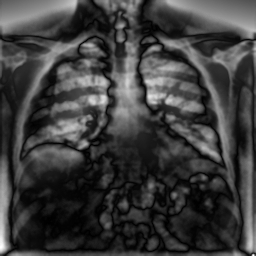

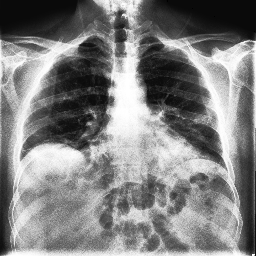

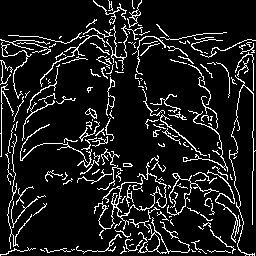

In [ ]:
# Testing the methods

img = cv2.imread('/content/drive/MyDrive/Data/train/COVID19/COVID19(5).jpg',0)
img = cv2.resize(img, (256, 256))

saliency_img = Saliency(img)
enhanced_img = HistEnhancemenet(img)
edged_img = CannyEdge(img)

cv2_imshow(saliency_img)
cv2_imshow(enhanced_img)
cv2_imshow(edged_img)



# Training models




In [ ]:
# train model

def train_model():

    image_data = tf.keras.preprocessing.image.ImageDataGenerator(
            #rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True
            #preprocessing_function = HistEnhancemenet
    )

    train_dir = '/content/drive/MyDrive/Data/train/'
    val_dir = '/content/drive/MyDrive/Data/val/'

    train_data = image_data.flow_from_directory(train_dir, target_size=(256, 256), batch_size=32,class_mode="categorical")
    val_data = image_data.flow_from_directory(val_dir, target_size=(256, 256), batch_size=32,class_mode="categorical")

    # classes
    print(train_data.class_indices)

    # classes
    classes_num = 3

    #instantiate the ResNet50 model
    input_t = keras.Input(shape= (256,256,3))
    base_model = keras.applications.ResNet50(include_top=False,
                                             weights='imagenet',
                                             input_tensor=input_t)
    

    # freeze training for all layers
    for layer in base_model.layers:
      layer.trainable = False
    
    # confirm if the layers are freezed or not
    #for i,layer in enumerate(base_model.layers):
     # print(i, layer.name, ' - ', layer.trainable)

    # create sequential model
   # start neural network

    model = keras.models.Sequential()

    # Add the ResNet50
    model.add(base_model)

    model.add(Flatten())

    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.3))

    #model.add(Dense(units=128, activation='relu'))
    #model.add(Dropout(0.3))

    #model.add(Dense(units=64, activation='relu'))
    #model.add(Dropout(0.3))

    model.add(layers.Dense(units=3, activation='softmax'))

    # compile the model
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss="mse", #keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    
    history =model.fit(train_data, validation_data=val_data, epochs=100)


    model.save("normal_modal.h5")


    



In [ ]:
train_model()


Found 2161 images belonging to 3 classes.
Found 643 images belonging to 3 classes.
{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
Epoch 1/100
68/68 [==============================] - 151s 2s/step - loss: 0.2226 - accuracy: 0.6603 - val_loss: 0.2239 - val_accuracy: 0.6594
Epoch 2/100
68/68 [==============================] - 141s 2s/step - loss: 0.1994 - accuracy: 0.6974 - val_loss: 0.2516 - val_accuracy: 0.6205
Epoch 3/100
68/68 [==============================] - 142s 2s/step - loss: 0.1840 - accuracy: 0.7219 - val_loss: 0.2422 - val_accuracy: 0.6330
Epoch 4/100
68/68 [==============================] - 142s 2s/step - loss: 0.1858 - accuracy: 0.7191 - val_loss: 0.2049 - val_accuracy: 0.6890
Epoch 5/100
68/68 [==============================] - 139s 2s/step - loss: 0.1836 - accuracy: 0.7219 - val_loss: 0.1799 - val_accuracy: 0.7278
Epoch 6/100
68/68 [==============================] - 142s 2s/step - loss: 0.1886 - accuracy: 0.7140 - val_loss: 0.1475 - val_accuracy: 0.7776
Epoch 7/100
68/68 [==

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
